Residual Blocks 

In theory, as the complexity of a problem/mapping increases, a relatively deeper/more complex neural network model is required to have a better performance. But in reality deep neural networks suffer from **degradation**, which is a term referring accuracy saturation followed by sudden degradation(sharp drop). This sharp drop is not caused by overfitting. 

The paper also shows that given two architectures that only defer by depth, and the difference is only compensated by adding identity layers, which supposedly leads to the deeper model should perform, if not better, on par with its shallow counterpart. However in reality, the shallow counterpart produces lower training error than the deeper model.

Residual blocks are introduced to counter degradation. Intuition here is that the initial signal is lost due to multiple activations through multiple layers. The straighforward thing to do is to introduce something called a skip connection. 

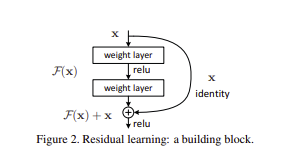

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
from typing import List 
from torchvision.transforms import ToTensor 

In [2]:
# Use conv3x3 to compute output
def conv3x3(in_channels, out_channels, kernel_size=3, stride=1):
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels= out_channels,
        kernel_size= kernel_size,
        stride=stride,
        padding=1
    )

class ResBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1
                 ) -> None:
        super(ResBlock, self).__init__()
        self.conv_1 = conv3x3(in_channels=in_channels, out_channels=out_channels, stride=stride)
        self.bn_1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv_2 = conv3x3(in_channels=out_channels, out_channels=out_channels)
        self.downsample = None
        if stride != 1 or in_channels!=out_channels:
            self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride)
        self.bn_2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        identity = x
        out = self.conv_1(x)
        out = self.bn_1(out)
        out = self.relu(out)
        
        out = self.conv_2(out)
        out = self.bn_2(out)
        
        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self,
                 num_classes=10
                 ) -> None:
        super(ResNet, self).__init__()
        self.layer1 = ResBlock(in_channels=1, out_channels=32)
        self.layer2 = ResBlock(in_channels=32, out_channels=64)
        self.layer3 = ResBlock(in_channels=64, out_channels=128, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=128, out_features=num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [18]:
train_dataset = MNIST("../Deep Learning/MNIST", 
                      download=True, 
                      train=True,
                      transform=ToTensor()
                      )
test_dataset = MNIST("../Deep Learning/MNIST",
                     download=True, 
                     train=False,
                     transform=ToTensor(),)

In [19]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2048)
test_dataloader = DataLoader(test_dataset, batch_size=2048)

In [ ]:
train_dataloader

In [9]:
def train(dataloader, model, config, device):
    model.train()
    epochs= config["epochs"]
    lr = config["lr"]
    loss_fn = config["loss_function"]
    optim = torch.optim.Adam(model.parameters())
    for e in range(1,epochs+1):
        running_loss = []
        for batch, data in enumerate(dataloader):
            X, y = data
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            running_loss.append(loss.item())
            optim.step()
            optim.zero_grad()
        print(f'Epoch {e}: {np.mean(running_loss)}')

In [10]:
config = {
    "epochs": 60,
    "lr": 0.001,
    "loss_function": nn.CrossEntropyLoss(),
}
model = ResNet()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device=device)

ResNet(
  (layer1): ResBlock(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): ResBlock(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): ResBlock(
    (conv_1): Conv2d(64, 128, kern

In [11]:
train(dataloader=train_dataloader,config=config,model=model, device=device)

/home/jawstan/ML-Quest/.venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1: 1.4725398500760396
Epoch 2: 0.4364956850806872
Epoch 3: 0.1837036023537318
Epoch 4: 0.12308022851745287
Epoch 5: 0.09384108905990919
Epoch 6: 0.07807394402722517
Epoch 7: 0.0656095369408528
Epoch 8: 0.05598523455361525
Epoch 9: 0.04930189289152622
Epoch 10: 0.04388616308569908
Epoch 11: 0.03953733413169781
Epoch 12: 0.03671464584767818
Epoch 13: 0.03291646211097638
Epoch 14: 0.028165608644485474
Epoch 15: 0.025787785028417904
Epoch 16: 0.02341541132579247
Epoch 17: 0.02153107300400734
Epoch 18: 0.019973794370889662
Epoch 19: 0.019059162586927414
Epoch 20: 0.01802463975424568
Epoch 21: 0.01682065650820732
Epoch 22: 0.014965151405582825
Epoch 23: 0.013642017139742772
Epoch 24: 0.011982920424391827
Epoch 25: 0.010607702269529303
Epoch 26: 0.009804818391179046
Epoch 27: 0.009004234227662285
Epoch 28: 0.008991850695262352
Epoch 29: 0.008346164242054026
Epoch 30: 0.007895179682721694
Epoch 31: 0.007889130618423223
Epoch 32: 0.007896597807606062
Epoch 33: 0.007784108072519303
Epoch 3

In [13]:
from sklearn.metrics import classification_report
def test(dataloader, model, config, device):
    model.eval()
    epochs= config["epochs"]
    for e in range(1,epochs+1):
        predictions = []
        ground_truth = []
        with torch.no_grad():
            for batch, data in enumerate(dataloader):
                X, y = data
                X = X.to(device)
                pred = model(X)
                pred = torch.argmax(pred,1)
                [predictions.append(x) for x in pred.cpu().numpy()]
                [ground_truth.append(x) for x in y.numpy()]
    print(classification_report(ground_truth, predictions))    

In [20]:
test(dataloader=test_dataloader,config=config,model=model, device=device)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       1.00      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.98      1.00      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

